In [79]:
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood, LeaveOneOutPseudoLikelihood
      
torch.set_default_dtype(torch.double)

def get_model(train_x, train_y, d=1):
    return SingleTaskGP(
        train_x, train_y, outcome_transform=Standardize(1), input_transform=Normalize(d)
    )

Setup (similar to Forrester et al. (2008)):
- function: $f(x) = 20 - (6x − 2)^2 \sin(12x − 4)$
- noise function: $r(x) = 1.1 + \sin(2\pi x)$.

In [58]:
def f(x):
    return 20 - (6 * x - 2)**2 * torch.sin(12 * x - 4)

def r(x):
    return 1.1 + torch.sin(2 * torch.pi * x)

train_x = torch.linspace(0, 1, 10).unsqueeze(-1)
train_x = torch.rand(50, 1)
train_x = torch.cat([train_x, torch.linspace(0.725, 0.875, 3).unsqueeze(-1)], dim=-2)
train_y_sem = r(train_x)
train_y = f(train_x) + train_y_sem * torch.randn_like(train_x)

In [59]:
# basic exact MLL
model_mll = get_model(train_x, train_y)
mll = ExactMarginalLogLikelihood(model_mll.likelihood, model_mll)
fit_gpytorch_mll(mll);
mll_state_dict = model_mll.state_dict()

In [60]:
# unweighted LOO-CV Pseudo-likelihood
model_loo = get_model(train_x, train_y)
loo = LeaveOneOutPseudoLikelihood(model_loo.likelihood, model_loo)
# load state dict to make sure we're not finding some other local solution
# far away from the MLL one if the MLL is multimodal
# model_loo.load_state_dict(mll_state_dict)
fit_gpytorch_mll(loo);

In [61]:
# weighted LOO-CV Pseudo-likelihood
from torch.nn.functional import softplus

model_loo_weighted = get_model(train_x, train_y)
loo_weighted = LeaveOneOutPseudoLikelihood(model_loo_weighted.likelihood, model_loo_weighted)
# model_loo_weighted.load_state_dict(mll_state_dict)

# weight data close to the "good" points higher
ymax = train_y.max()
ymin = train_y.min()
eta = 1.0  # hyperparameter
weights = softplus(-eta * (ymax - train_y.flatten()) / (ymax - ymin))
# normalize weights so they are 1 on average
weights = train_y.shape[-2] * weights / weights.sum()
# weights = torch.ones(len(train_y))

fit_gpytorch_mll(loo_weighted, closure_kwargs={"weights": weights});

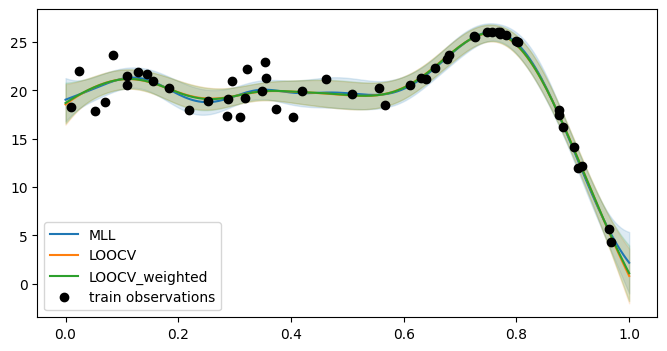

In [62]:
# visualize model fits

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

test_x = torch.linspace(0, 1, 200).unsqueeze(-1)


for model, name in zip(
    [model_mll, model_loo, model_loo_weighted],
    ["MLL", "LOOCV", "LOOCV_weighted"],
):  
    with torch.no_grad():
        post = model.posterior(test_x)
    lower, upper = post.mvn.confidence_region()
    l = ax.plot(test_x.flatten(), post.mean.flatten(), label=name)
    ax.fill_between(test_x.flatten(), lower.flatten(), upper.flatten(), alpha=0.15, color=l[0].get_color())
    
ax.plot(train_x.flatten(), train_y.flatten(), "ok", label="train observations")
ax.legend()

In [63]:
model_mll.likelihood.noise

Parameter containing:
tensor([0.0801], requires_grad=True)

In [64]:
model_loo.likelihood.noise

Parameter containing:
tensor([0.0834], requires_grad=True)

In [65]:
model_loo_weighted.likelihood.noise

Parameter containing:
tensor([0.0819], requires_grad=True)

## Feels like this may be more interesting in higher dims

In [142]:
from botorch.test_functions import Hartmann

H = Hartmann(negate=True)

n_train = 40
train_x = torch.rand(n_train, 6)
train_y = H(train_x) + 0.001 * torch.randn(n_train)
train_y = train_y.unsqueeze(-1)

In [143]:
# basic exact MLL
model_mll = get_model(train_x, train_y, d=H.dim)
mll = ExactMarginalLogLikelihood(model_mll.likelihood, model_mll)
fit_gpytorch_mll(mll);
mll_state_dict = model_mll.state_dict()

In [144]:
# unweighted LOO-CV Pseudo-likelihood
model_loo = get_model(train_x, train_y, d=H.dim)
loo = LeaveOneOutPseudoLikelihood(model_loo.likelihood, model_loo)
# load state dict to make sure we're not finding some other local solution
# far away from the MLL one if the MLL is multimodal
# model_loo.load_state_dict(mll_state_dict)
fit_gpytorch_mll(loo);

In [145]:
# weighted LOO-CV Pseudo-likelihood
from torch.nn.functional import softplus

model_loo_weighted = get_model(train_x, train_y, d=H.dim)
loo_weighted = LeaveOneOutPseudoLikelihood(model_loo_weighted.likelihood, model_loo_weighted)
# model_loo_weighted.load_state_dict(mll_state_dict)

# weight data close to the "good" points higher
ymax = train_y.max()
ymin = train_y.min()
eta = 2.0  # hyperparameter
weights = softplus(-eta * (ymax - train_y.flatten()) / (ymax - ymin)) # this can probably be improved a bunch
# normalize weights so they are 1 on average
weights = train_y.shape[-2] * weights / weights.sum()
# weights = torch.ones(len(train_y))

fit_gpytorch_mll(loo_weighted, closure_kwargs={"weights": weights});

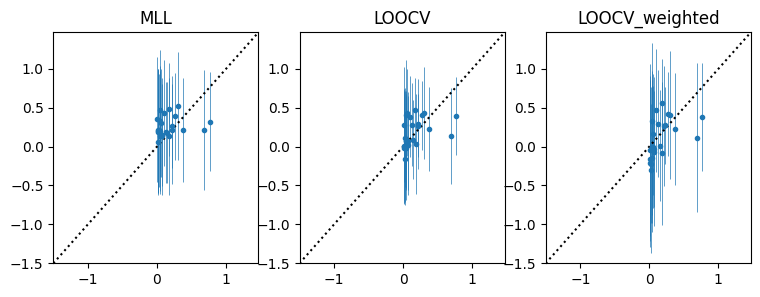

In [146]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

n_test = 25
test_x = torch.rand(n_test, 6)
test_y = H(test_x)


pmin, pmax = float("inf"), -float("inf")

for model, name, ax in zip(
    [model_mll, model_loo, model_loo_weighted],
    ["MLL", "LOOCV", "LOOCV_weighted"],
    axs
):  
    with torch.no_grad():
        post = model.posterior(test_x)
    ax.errorbar(
        x=test_y,
        y=post.mean.flatten(),
        yerr=2*post.variance.flatten().sqrt(),
        linestyle="",
        marker="o",
        markersize=3,
        elinewidth=0.5
    )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    pmin = min(pmin, xmin, ymin)
    pmax = max(pmax, xmax, ymax)
    ax.set_title(name)

for ax in axs:
    ax.set_xlim(pmin, pmax)
    ax.set_ylim(pmin, pmax)
    ax.plot([pmin, pmax], [pmin, pmax], "k:")